# Modeling microbiota-wide metabolism with MICOM

This notebook will accompany the second session of the 2020 ISB Microbiome Course.

In [1]:
output_dir = "/data/scratch/kvalem/projects/2024/diabetes_microbe/05-results/figures"

## Basic Installation

In [2]:
#!git clone https://github.com/gibbons-lab/isb_course_2020 materials
# %cd materials

In [3]:
!pip install -q micom

# print("Done! 🎉 ")

## Enable QIIME 2 interactions

In [4]:
#!pip install -q numpy Cython
#!pip install -q biom-format

# print("Done! 🎉 ")

# MICOM
MICOM starts from a combined abundance/taxonomy table, which MICOM abbreviates to a taxonomy table. To see how those tables look we can import MICOM and look at an example table:


## Importing data from QIIME 2
Model database to use:  [AGORA database](https://pubmed.ncbi.nlm.nih.gov/27893703/), which is a curated database of more than 800 bacterial strains that commonly live in the human gut. 

Version database summarized on the genus rank which can be downloaded from [MICOM data repository](https://doi.org/10.5281/zenodo.3755182) 

In [5]:
#!wget -O agora103_genus.qza https://zenodo.org/record/3755182/files/agora103_genus.qza?download=1

In [6]:
from micom.qiime_formats import load_qiime_medium
import pandas as pd
from micom.workflows import build
from micom import Community
import pandas as pd
from micom.workflows import grow
import pickle
from micom.viz import *
from micom.viz import *
import numpy as np
import pandas as pd
from micom.measures import production_rates
from micom.viz import plot_association
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from micom.taxonomy import qiime_to_micom

In [7]:

#tax = qiime_to_micom(
#    "/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_vsearch/qiime2/input/table.qza",
#    "/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_vsearch/qiime2/input/taxonomy.qza",
#    collapse_on="genus",
#)


tax = qiime_to_micom(
    "/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/materials/table.qza",
    "/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/materials/taxonomy.qza",
    collapse_on="genus",
)

In [8]:
tax

sample_id  abundance               genus                  id  relative
0     s20011_0001     2278.0         Akkermansia         Akkermansia  0.070077
1     s20011_0002        3.0         Akkermansia         Akkermansia  0.000114
2     s20011_0003     1745.0         Akkermansia         Akkermansia  0.062774
3     s20011_0004      105.0         Akkermansia         Akkermansia  0.009201
4     s20011_0005      111.0         Akkermansia         Akkermansia  0.003539
...           ...        ...                 ...                 ...       ...
4094  s20011_0047        3.0         Floricoccus         Floricoccus  0.000119
4095  s20011_0018        2.0          Isobaculum          Isobaculum  0.000048
4096  s20011_0024        2.0  Celerinatantimonas  Celerinatantimonas  0.000070
4097  s20011_0028        2.0        Murdochiella        Murdochiella  0.000096
4098  s20011_0040        1.0       Pluralibacter       Pluralibacter  0.000018

[4051 rows x 5 columns]

### Merge metadata

In [9]:
metadata = pd.read_table(
    #"/data/scratch/kvalem/projects/2024/Effenberger-Diabetes/02-scripts/nf-core_ampliseq/metadata.tsv"
    "/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/nf-core_ampliseq/metadata_new.tsv"
).rename(columns={"id": "sample_id"})

In [10]:
metadata

sample_id sample_information  age  KHK1  KHK2   CA1   CA2  \
0   s20011_0048              PDM12   75    ja  nein    ja    ja   
1   s20011_0023              PDM17   71    ja    ja    ja    ja   
2   s20011_0019                DM4   39  nein  nein  nein  nein   
3   s20011_0002               PDM1   71    ja    ja  nein  nein   
4   s20011_0007               PDM2   69    ja    ja  nein  nein   
5   s20011_0008              PDM14   69    ja    ja  nein  nein   
6   s20011_0003              PDM13   68  nein    ja  nein  nein   
7   s20011_0033                DM7   66    ja    ja  nein  nein   
8   s20011_0022               PDM5   65    ja    ja    ja    ja   
9   s20011_0018              PDM16   66    ja    ja    ja    ja   
10  s20011_0014                DM3   54    ja    ja  nein  nein   
11  s20011_0013              PDM15   62  nein  nein  nein  nein   
12  s20011_0044              PDM10   62  nein  nein  nein    ja   
13  s20011_0037                DM8   61  nein  nein  nein  nein   
14  s20011_0041                DM9   55  nein  nein  nein  nein   
15  s20011_0004                DM1   50    ja  nein  nein  nein   
16  s20011_0029                DM6   52  nein  nein  nein  nein   
17  s20011_0027               PDM6   74    ja    ja  nein  nein   
18  s20011_0010               DM14   51    ja    ja  nein  nein   
19  s20011_0042               DM21   53  nein  nein  nein  nein   
20  s20011_0036               PDM8   49  nein    ja  nein  nein   
21  s20011_0005               DM13   19  nein  nein  nein  nein   
22  s20011_0032               PDM7   48  nein  nein  nein  nein   
23  s20011_0012               PDM3   47  nein  nein  nein  nein   
24  s20011_0046              PDM11   44  nein  nein  nein  nein   
25  s20011_0015               DM15   31  nein  nein  nein  nein   
26  s20011_0030               DM18   26  nein  nein  nein  nein   
27  s20011_0009                DM2   51  nein  nein  nein  nein   
28  s20011_0020               DM16   61    ja    ja  nein  nein   
29  s20011_0047               DM11   28  nein  nein  nein  nein   
30  s20011_0025               DM17   29  nein  nein  nein  nein   
31  s20011_0024                DM5   43  nein  nein  nein  nein   
32  s20011_0049               DM12   40  nein  nein  nein  nein   
33  s20011_0040               PDM9   56  nein  nein  nein  nein   
34  s20011_0028              PDM18   56  nein  nein  nein  nein   
35  s20011_0034               DM19   32  nein  nein  nein  nein   
36  s20011_0038               DM20   50  nein  nein  nein  nein   
37  s20011_0045               DM10   30  nein  nein  nein  nein   
38  s20011_0017               PDM4   60    ja    ja    ja    ja   
39  s20011_0001                 K1   56  nein  nein  nein  nein   
40  s20011_0006                 K2   58  nein  nein  nein  nein   
41  s20011_0011                 K3   60  nein  nein  nein  nein   
42  s20011_0016                 K4   77  nein  nein  nein  nein   
43  s20011_0021                 K5   59  nein  nein  nein  nein   
44  s20011_0026                 K6   60  nein  nein  nein  nein   
45  s20011_0031                 K7   18  nein  nein  nein  nein   
46  s20011_0035                 K8   62  nein  nein  nein  nein   
47  s20011_0039                 K9   67  nein  nein  nein  nein   
48  s20011_0043                K10   45  nein  nein  nein  nein   

    HbA1C (DCCT/NGSP)1  HbA1C (DCCT/NGSP)2  Glukose1  Glukose2  BMI1  BMI2  \
0                  7.4                 8.6        92     303.0  22.6  24.9   
1                  8.7                 7.7       160      70.0  20.3  20.3   
2                  8.1                 7.6       309      92.0  21.6  22.8   
3                  6.7                 8.2       128       5.3  18.5  18.8   
4                  7.4                 7.2       139     263.0  28.6  26.9   
5                  8.5                 8.3       154     275.0  32.1  32.1   
6                  7.7                 8.7        84     192.0  34.4  36.5   
7                  6.9         

In [11]:
tax = pd.merge(tax, metadata, on="sample_id")
tax

sample_id  abundance               genus                  id  \
0     s20011_0001     2278.0         Akkermansia         Akkermansia   
1     s20011_0002        3.0         Akkermansia         Akkermansia   
2     s20011_0003     1745.0         Akkermansia         Akkermansia   
3     s20011_0004      105.0         Akkermansia         Akkermansia   
4     s20011_0005      111.0         Akkermansia         Akkermansia   
...           ...        ...                 ...                 ...   
4046  s20011_0047        3.0         Floricoccus         Floricoccus   
4047  s20011_0018        2.0          Isobaculum          Isobaculum   
4048  s20011_0024        2.0  Celerinatantimonas  Celerinatantimonas   
4049  s20011_0028        2.0        Murdochiella        Murdochiella   
4050  s20011_0040        1.0       Pluralibacter       Pluralibacter   

      relative sample_information  age  KHK1  KHK2   CA1  ... Glukose1  \
0     0.070077                 K1   56  nein  nein  nein  ...       99   
1     0.000114               PDM1   71    ja    ja  nein  ...      128   
2     0.062774              PDM13   68  nein    ja  nein  ...       84   
3     0.009201                DM1   50    ja  nein  nein  ...      111   
4     0.003539               DM13   19  nein  nein  nein  ...      106   
...        ...                ...  ...   ...   ...   ...  ...      ...   
4046  0.000119               DM11   28  nein  nein  nein  ...      239   
4047  0.000048              PDM16   66    ja    ja    ja  ...      110   
4048  0.000070                DM5   43  nein  nein  nein  ...       85   
4049  0.000096              PDM18   56  nein  nein  nein  ...      167   
4050  0.000018               PDM9   56  nein  nein  nein  ...      120   

      Glukose2  BMI1  BMI2      Pankreatektomie  HbA1C_diff  Glukose_diff  \
0         89.0  23.9  24.1                 nein    increase      decrease   
1          5.3  18.5  18.8                 nein    increase      decrease   
2        192.0  34.4  36.5                 nein    increase      increase   
3        131.0  28.2  31.9                 nein    decrease      increase   
4         88.0  18.7  21.2                 nein    decrease      decrease   
...        ...   ...   ...                  ...         ...           ...   
4046     267.0  23.1  25.1                 nein    increase      increase   
4047     120.0  28.2  28.8  Teilresektion links    decrease      increase   
4048      88.0  26.1  26.1                 nein    increase      increase   
4049     143.0  24.2  22.6            Resektion    increase      decrease   
4050     121.0  18.8  20.5            Resektion    increase      increase   

      BMI_diff    KHK_diff     CA_diff  
0     increase      absent      absent  
1     increase  persistent      absent  
2     increase       onset      absent  
3     increase    resolved      absent  
4     increase      absent      absent  
...        ...         ...         ...  
4046  increase      absent      absent  
4047  increase  persistent  persistent  
4048  decrease      absent      absent  
4049  decrease      absent      absent  
4050  increase      absent      absent  

[4051 rows x 23 columns]

## Building community models

In [12]:
#manifest = build(
#    tax, "agora103_genus.qza", "models", solver="osqp", cutoff=2.5e-2, threads=2
#)

For different data a warning may pop up if less than 50% of the abundances can be matched to the database. If this happens, you can still continue, but be aware that such a sparse model may not accurately represent your sample. In lower-biomass 16S amplicon sequencing samples from stool, many reads can match to food components or to host mitochondria and these hits probably do not contribute much to bacterial community metabolism. These hits will be excluded from MICOM. 

We won't see any warnings here. So, we will go ahead for now. Let's also take a look what we got back from the `build` process.

In [13]:
#manifest.to_csv("manifest.tsv", sep="\t")
#manifest.to_csv("/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/manifest.tsv", sep="\t")

In [14]:
#manifest = pd.read_csv("manifest.tsv", sep="\t")
manifest = pd.read_csv("/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/materials/manifest.tsv", sep="\t")

## Simulating growth

'average Western Diet' to each individual. [MICOM data repository](https://doi.org/10.5281/zenodo.3755182).

In [15]:
#!wget -O western_diet_gut.qza https://zenodo.org/record/3755182/files/western_diet_gut.qza?download=1

This is again a QIIME 2 artifact, which we can load into MICOM.

In [16]:
#medium = load_qiime_medium("western_diet_gut.qza")
medium = load_qiime_medium("/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/materials/western_diet_gut.qza")
medium

flux  dilution metabolite    reaction
reaction                                             
EX_fru_m    0.014899     0.100      fru_m    EX_fru_m
EX_glc_m    0.014899     0.100      glc_m    EX_glc_m
EX_gal_m    0.014899     0.100      gal_m    EX_gal_m
EX_man_m    0.014899     0.100      man_m    EX_man_m
EX_mnl_m    0.014899     0.100      mnl_m    EX_mnl_m
...              ...       ...        ...         ...
EX_glu_D_m  0.100000     0.100    glu_D_m  EX_glu_D_m
EX_gthrd_m  0.100000     0.100    gthrd_m  EX_gthrd_m
EX_h2_m     0.100000     0.100       h2_m     EX_h2_m
EX_no2_m    0.100000     0.100      no2_m    EX_no2_m
EX_o2_m     0.001000     0.001       o2_m     EX_o2_m

[170 rows x 4 columns]

In [17]:
#growth_results = grow(manifest, "models", medium, tradeoff=0.5, threads=2)

#pickle.dump(growth_results, open("growth.pickle", "wb"))
#pickle.dump(growth_results, open("/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/growth.pickle", "wb"))

In [19]:
# try:
#  growth_results
# except NameError:
growth_results = pickle.load(open("/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/materials/growth.pickle", "rb"))

In [20]:
growth_results.growth_rates.head()

abundance  growth_rate  reactions  metabolites        taxon  \
compartments                                                                
Bacteroides    0.929622     0.200480       3307         1887  Bacteroides   
Blautia        0.070378     0.019651       3108         1818      Blautia   
Akkermansia    0.099298     0.046649       2274         1386  Akkermansia   
Bacteroides    0.641559     0.259024       3307         1887  Bacteroides   
Blautia        0.193235     0.079613       3108         1818      Blautia   

              tradeoff    sample_id  
compartments                         
Bacteroides        0.5  s20011_0002  
Blautia            0.5  s20011_0002  
Akkermansia        0.5  s20011_0001  
Bacteroides        0.5  s20011_0001  
Blautia            0.5  s20011_0001

Exchange fluxes.

- How much of each metabolite is either consumed or produced by each taxon in each sample. 
- Tolerance denotes the accuracy of the solver and tells you the smallest absolute flux that is likely different form zero (i.e. substantial flux).
- *All of the fluxes are normalized to 1g dry weight of bacteria*. So, you can directly compare fluxes between taxa, even if they are present at very different abundances. 


In [21]:
anns = growth_results.annotations

In [22]:
anns

metabolite                       name  molecular_weight  \
reaction                                                                 
EX_12ppd_S(e)  12ppd_S[e]       (S)-propane-1,2-diol          76.09442   
EX_2obut(e)      2obut[e]             2-Oxobutanoate         101.08070   
EX_4abut(e)      4abut[e]           4-Aminobutanoate         103.11976   
EX_4hbz(e)        4hbz[e]          4-hydroxybenzoate         137.11280   
EX_MGlcn10(e)  MGlcn10[e]  mucin-type O-glycan No 10               NaN   
...                   ...                        ...               ...   
EX_phpyr_m        phpyr_m        keto-phenylpyruvate         163.15008   
EX_btoh(e)        btoh[e]                    butanol          74.12160   
EX_btoh_m          btoh_m                    butanol          74.12160   
EX_pppn(e)        pppn[e]           Phenylpropanoate         149.16656   
EX_pppn_m          pppn_m           Phenylpropanoate         149.16656   

               C_number  N_number       hmdb  \
reaction                                       
EX_12ppd_S(e)         3         0  HMDB06213   
EX_2obut(e)           4         0  HMDB00005   
EX_4abut(e)           4         1  HMDB00112   
EX_4hbz(e)            7         0  HMDB00500   
EX_MGlcn10(e)        44         4        NaN   
...                 ...       ...        ...   
EX_phpyr_m            9         0  HMDB00205   
EX_btoh(e)            4         0        NaN   
EX_btoh_m             4         0        NaN   
EX_pppn(e)            9         0        NaN   
EX_pppn_m             9         0        NaN   

                                                           inchi  \
reaction                                                           
EX_12ppd_S(e)  InChI=1S/C3H8O2/c1-3(5)2-4/h3-5H,2H2,1H3/t3-/m...   
EX_2obut(e)    InChI=1S/C4H6O3/c1-2-3(5)4(6)7/h2H2,1H3,(H,6,7...   
EX_4abut(e)     InChI=1S/C4H9NO2/c5-3-1-2-4(6)7/h1-3,5H2,(H,6,7)   
EX_4hbz(e)     InChI=1S/C7H6O3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8...   
EX_MGlcn10(e)                                                NaN   
...                                                          ...   
EX_phpyr_m     InChI=1S/C9H8O3/c10-8(9(11)12)6-7-4-2-1-3-5-7/...   
EX_btoh(e)                                                   NaN   
EX_btoh_m                                                    NaN   
EX_pppn(e)                                                   NaN   
EX_pppn_m                                                    NaN   

              kegg.compound pubchem.compound       reaction  
reaction                                                     
EX_12ppd_S(e)        C02917              NaN  EX_12ppd_S(e)  
EX_2obut(e)          C00109               58    EX_2obut(e)  
EX_4abut(e)          C00334              119    EX_4abut(e)  
EX_4hbz(e)           C00156              NaN     EX_4hbz(e)  
EX_MGlcn10(e)           NaN              NaN  EX_MGlcn10(e)  
...                     ...              ...            ...  
EX_phpyr_m           C00166              997     EX_phpyr_m  
EX_btoh(e)           C06142              NaN     EX_btoh(e)  
EX_btoh_m            C06142              NaN      EX_btoh_m  
EX_pppn(e)              NaN              NaN     EX_pppn(e)  
EX_pppn_m               NaN              NaN      EX_pppn_m  

[1534 rows x 10 columns]

In [23]:
anns[anns.metabolite == "ser_L_m"]

metabolite      name  molecular_weight  C_number  N_number  \
reaction                                                                
EX_ser_L_m    ser_L_m  L-serine         105.09258         3         1   

                 hmdb                                              inchi  \
reaction                                                                   
EX_ser_L_m  HMDB00187  InChI=1S/C3H7NO3/c4-2(1-5)3(6)7/h2,5H,1,4H2,(H...   

           kegg.compound pubchem.compound    reaction  
reaction                                               
EX_ser_L_m        C00065             5951  EX_ser_L_m

In [24]:
from micom.interaction import interactions

ints = interactions(growth_results, taxa="Akkermansia")
ints.sort_values(by="flux", ascending=False).head()

/home/kvalem/.local/lib/python3.11/site-packages/micom/interaction/focal.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: _metabolite_interaction(df, taxon, p))
/home/kvalem/.local/lib/python3.11/site-packages/micom/interaction/focal.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: _metabolite_interaction(df, taxon, p))
/home/kvalem/.local/lib/python3.11/site-packages/micom

metabolite        focal      partner     class       flux    sample_id  \
3330     h2o[e]  Akkermansia  Bacteroides  provided  58.353331  s20011_0044   
3335   lac_D[e]  Akkermansia  Bacteroides  provided  58.353331  s20011_0044   
3191    etoh[e]  Akkermansia  Bacteroides  received  56.055656  s20011_0042   
2733       h[e]  Akkermansia  Bacteroides  provided  51.588592  s20011_0031   
2737   lac_D[e]  Akkermansia  Bacteroides  provided  51.588592  s20011_0031   

             name  molecular_weight  C_number  N_number       hmdb  \
3330        Water          18.01528         0         0  HMDB02111   
3335  (R)-lactate          89.07000         3         0  HMDB01311   
3191      ethanol          46.06844         2         0  HMDB00108   
2733       proton           1.00794         0         0  HMDB01362   
2737  (R)-lactate          89.07000         3         0  HMDB01311   

                                                  inchi kegg.compound  \
3330                                  InChI=1S/H2O/h1H2        C00001   
3335  InChI=1S/C3H6O3/c1-2(4)3(5)6/h2,4H,1H3,(H,5,6)...        C00256   
3191                  InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3        C00469   
2733                                  InChI=1S/p+1/i/hH        C00282   
2737  InChI=1S/C3H6O3/c1-2(4)3(5)6/h2,4H,1H3,(H,5,6)...        C00256   

     pubchem.compound     reaction  
3330              962    EX_h2o(e)  
3335            61503  EX_lac_D(e)  
3191              702   EX_etoh(e)  
2733             1038      EX_h(e)  
2737            61503  EX_lac_D(e)

In [25]:
from micom.interaction import summarize_interactions

summary = summarize_interactions(ints)
summary.head()

/home/kvalem/.local/lib/python3.11/site-packages/micom/interaction/summary.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return ints.groupby("class").apply(
/home/kvalem/.local/lib/python3.11/site-packages/micom/interaction/summary.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return ints.groupby("class").apply(
/home/kvalem/.local/lib/python3.11/site-packages/micom/interaction/summary.py:8: FutureWarning

sample_id        focal      partner        class       flux  mass_flux  \
0  s20011_0001  Akkermansia  Bacteroides  co-consumed  19.572640   0.900213   
1  s20011_0001  Akkermansia  Bacteroides     provided  24.138327   3.357148   
2  s20011_0001  Akkermansia  Bacteroides     received  57.570654   5.147628   
3  s20011_0001  Akkermansia      Blautia  co-consumed  49.889955   3.802154   
4  s20011_0001  Akkermansia      Blautia     provided  65.066159   3.374423   

       C_flux     N_flux  n_ints  
0   28.245786   0.248609      29  
1  146.238162  17.442684       5  
2  202.067623  10.608325      12  
3  129.163600  10.173472      31  
4  108.256297   2.853033       8

In [26]:
full = interactions(growth_results, taxa=None, threads=8)
full.shape

Output()

/home/kvalem/.local/lib/python3.11/site-packages/micom/interaction/focal.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: _metabolite_interaction(df, taxon, p))
/home/kvalem/.local/lib/python3.11/site-packages/micom/interaction/focal.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: _metabolite_interaction(df, taxon, p))
/home/kvalem/.local/lib/python3.11/site-packages/micom

(66310, 15)

In [27]:
full.head()

sample_id  metabolite         focal    partner        class       flux  \
0  s20011_0004  26dap_M[e]  Butyrivibrio  Alistipes  co-consumed   0.000509   
1  s20011_0004    acald[e]  Butyrivibrio  Alistipes     provided   4.417387   
2  s20011_0004    ala_D[e]  Butyrivibrio  Alistipes  co-consumed  10.759910   
3  s20011_0004    asn_L[e]  Butyrivibrio  Alistipes     received  10.759910   
4  s20011_0004    asp_L[e]  Butyrivibrio  Alistipes  co-consumed  10.759910   

                            name  molecular_weight  C_number  N_number  \
0  meso-2,6-Diaminoheptanedioate         190.19706         7         2   
1                   acetaldehyde          44.05256         2         0   
2                      D-alanine          89.09318         3         1   
3                   L-asparagine         132.11792         4         2   
4                L-aspartate(1-)         132.09474         4         1   

        hmdb                                              inchi kegg.compound  \
0        NaN                                                NaN           NaN   
1  HMDB00990                      InChI=1S/C2H4O/c1-2-3/h2H,1H3        C00084   
2  HMDB01310  InChI=1S/C3H7NO2/c1-2(4)3(5)6/h2H,4H2,1H3,(H,5...        C00133   
3  HMDB00168  InChI=1S/C4H8N2O3/c5-2(4(8)9)1-3(6)7/h2H,1,5H2...        C00152   
4  HMDB00191  InChI=1S/C4H7NO4/c5-2(4(8)9)1-3(6)7/h2H,1,5H2,...        C00049   

  pubchem.compound       reaction  
0              NaN  EX_26dap_M(e)  
1              177    EX_acald(e)  
2            71080    EX_ala_D(e)  
3             6267    EX_asn_L(e)  
4             5960    EX_asp_L(e)

In [28]:
full_summary = summarize_interactions(full)
full_summary.shape

/home/kvalem/.local/lib/python3.11/site-packages/micom/interaction/summary.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return ints.groupby("class").apply(
/home/kvalem/.local/lib/python3.11/site-packages/micom/interaction/summary.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return ints.groupby("class").apply(
/home/kvalem/.local/lib/python3.11/site-packages/micom/interaction/summary.py:8: FutureWarning

(3826, 9)

In [29]:
full_summary.head()

sample_id        focal      partner        class       flux  mass_flux  \
0  s20011_0001  Akkermansia  Bacteroides  co-consumed  19.572640   0.900213   
1  s20011_0001  Akkermansia  Bacteroides     provided  24.138327   3.357148   
2  s20011_0001  Akkermansia  Bacteroides     received  57.570654   5.147628   
3  s20011_0001  Akkermansia      Blautia  co-consumed  49.889955   3.802154   
4  s20011_0001  Akkermansia      Blautia     provided  65.066159   3.374423   

       C_flux     N_flux  n_ints  
0   28.245786   0.248609      29  
1  146.238162  17.442684       5  
2  202.067623  10.608325      12  
3  129.163600  10.173472      31  
4  108.256297   2.853033       8

# Visualizations

### Growth rates for each taxon.

In [30]:
viz = plot_growth(growth_results)

In [31]:
viz

In [ ]:
#results 
#"/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/growth_rates_20250624.html"

## Growth niches

1. What dietary nutrients are consumed by the microbiota `plot_exchanges_per_sample`
2. What metabolites do the microbiota produce?' 

In [32]:
plot_exchanges_per_sample(growth_results)

In [33]:
plot_exchanges_per_taxon(growth_results, perplexity=4, direction="import")

In [34]:
#results 
#"/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/taxon_exchanges_20250624.html"

In [35]:
exchanges = growth_results.exchanges
exchanges = pd.merge(exchanges, metadata, on="sample_id")
exchanges

taxon    sample_id  tolerance         reaction        flux  \
0      Akkermansia  s20011_0001   0.000001       EX_etoh(e) -100.000000   
1      Akkermansia  s20011_0001   0.000001      EX_acnam(e)   -1.007068   
2      Akkermansia  s20011_0001   0.000001      EX_his_L(e)   -0.003698   
3      Akkermansia  s20011_0001   0.000001      EX_2obut(e)   -0.019227   
4      Akkermansia  s20011_0001   0.000001        EX_nh4(e)   -2.321091   
...            ...          ...        ...              ...         ...   
21807       medium  s20011_0049   0.000001       EX_pheme_m   -0.000513   
21808       medium  s20011_0049   0.000001       EX_leu_L_m   -0.015000   
21809       medium  s20011_0049   0.000001         EX_nmn_m   -0.100000   
21810       medium  s20011_0049   0.000001         EX_cu2_m   -0.001142   
21811       medium  s20011_0049   0.000001  EX_starch1200_m   -0.000012   

       abundance    metabolite direction sample_information  age  ...  \
0       0.099298       etoh[e]    import                 K1   56  ...   
1       0.099298      acnam[e]    import                 K1   56  ...   
2       0.099298      his_L[e]    import                 K1   56  ...   
3       0.099298      2obut[e]    import                 K1   56  ...   
4       0.099298        nh4[e]    import                 K1   56  ...   
...          ...           ...       ...                ...  ...  ...   
21807        NaN       pheme_m    import               DM12   40  ...   
21808        NaN       leu_L_m    import               DM12   40  ...   
21809        NaN         nmn_m    import               DM12   40  ...   
21810        NaN         cu2_m    import               DM12   40  ...   
21811        NaN  starch1200_m    import               DM12   40  ...   

      Glukose1 Glukose2  BMI1  BMI2  Pankreatektomie  HbA1C_diff  \
0           99     89.0  23.9  24.1             nein    increase   
1           99     89.0  23.9  24.1             nein    increase   
2           99     89.0  23.9  24.1             nein    increase   
3           99     89.0  23.9  24.1             nein    increase   
4           99     89.0  23.9  24.1             nein    increase   
...        ...      ...   ...   ...              ...         ...   
21807      102    101.0  24.8  25.2             nein    increase   
21808      102    101.0  24.8  25.2             nein    increase   
21809      102    101.0  24.8  25.2             nein    increase   
21810      102    101.0  24.8  25.2             nein    increase   
21811      102    101.0  24.8  25.2             nein    increase   

       Glukose_diff  BMI_diff  KHK_diff  CA_diff  
0          decrease  increase    absent   absent  
1          decrease  increase    absent   absent  
2          decrease  increase    absent   absent  
3          decrease  increase    absent   absent  
4          decrease  increase    absent   absent  
...             ...       ...       ...      ...  
21807      decrease  increase    absent   absent  
21808      decrease  increase    absent   absent  
21809      decrease  increase    absent   absent  
21810      decrease  increase    absent   absent  
21811      decrease  increase    absent   absent  

[21812 rows x 26 columns]

In [43]:
def assign_condition(info):
    if "PDM" in info:
        return "T3cDM"
    elif "K" in info:
        return "H"
    else:
        return "T1DM"

exchanges['condition'] = exchanges['sample_information'].apply(assign_condition)

In [ ]:
#exchanges.to_csv("growthresults_exchanges.tsv", sep = "\t")

### Plotting flux

In [ ]:
#exchange_fluxes = pd.read_csv("./tmp_results/exchange_fluxes.csv")
exchange_fluxes = pd.read_csv("/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/materials/exchange_fluxes.csv")

In [44]:
filtered_df = exchanges

In [ ]:
filtered_df['flux'] = pd.to_numeric(filtered_df['flux'], errors='coerce')
filtered_df['abundance'] = pd.to_numeric(filtered_df['abundance'], errors='coerce')

h2s_df = filtered_df[filtered_df['metabolite'] == 'h2s[e]'].copy()

barplot_data = (
    h2s_df
    .groupby(['taxon', 'condition'])['flux']
    .mean()
    .reset_index()
)

taxon_order = (
    barplot_data.groupby('taxon')['flux']
    .sum()
    .sort_values()
    .index
)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=barplot_data,
    y='taxon',
    x='flux',
    hue='condition',
    order=taxon_order
)
plt.title("Flux of h2s[e] by Taxon and Condition")
plt.xlabel("Mean Flux")
plt.ylabel("Taxon")
plt.tight_layout()
plt.show()

In [ ]:
import itertools

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind

metabolites_of_interest = significant_metabolites


conditions = exchanges["condition"].unique().tolist()
comparisons = list(itertools.combinations(conditions, 2))

n_cols = 3
n_rows = (len(metabolites_of_interest) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
axes = axes.flatten()

for i, metabolite in enumerate(metabolites_of_interest):
    ax = axes[i]
    df = exchanges[exchanges["description"] == metabolite]

    if df.empty:
        ax.set_visible(False)
        continue

    
    sns.boxplot(data=df, x="condition", y="flux", ax=ax, showcaps=True,
                boxprops={'facecolor': 'None'}, showfliers=False,
                whiskerprops={'linewidth': 2}, medianprops={'color': 'black'})
    
    sns.swarmplot(data=df, x="condition", y="flux", ax=ax, color=".25", size=4)

    
    y_max = df["flux"].max()
    y_start = y_max * 1.05
    h = y_max * 0.05

    for j, (cond1, cond2) in enumerate(comparisons):
        group1 = df[df["condition"] == cond1]["flux"]
        group2 = df[df["condition"] == cond2]["flux"]

        if group1.empty or group2.empty:
            continue

        stat, pval = ttest_ind(group1, group2)
        x1 = conditions.index(cond1)
        x2 = conditions.index(cond2)
        y = y_start + j * h * 1.5
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.2, c='black')
        ax.text((x1 + x2) / 2, y + h * 1.05, f"p = {pval:.3e}", ha='center', va='bottom', fontsize=8)

    ax.set_title(metabolite, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("Flux", fontsize=9)
    ax.tick_params(axis='x', rotation=45)


for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

pdf_path = "metabolite_flux_comparison_plots.pdf"

pdf.savefig(fig)#

print(f"PDF saved to: {pdf_path}")

In [ ]:
exchange_fluxes_female = exchange_fluxes[exchange_fluxes["AH"] == "yes"]

In [ ]:
heatmap_data = exchange_fluxes_female.pivot_table(
    index="description",  
    columns="sample_information", 
    values="flux", 
    aggfunc="mean", 
)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import zscore

flux_matrix = exchange_fluxes_female.pivot_table(
    index="description", columns="sample_information", values="flux", aggfunc="mean"
)

flux_z = flux_matrix.apply(zscore, axis=1, nan_policy="omit")
flux_z = flux_z.dropna(how="all")

plt.figure(figsize=(12, 8))
sns.heatmap(flux_z, cmap="Spectral_r", center=0, linewidths=0.5, linecolor="gray")
plt.title("Z-scored Flux Heatmap by Sample")
plt.xlabel("Sample Information")
plt.ylabel("Metabolite")
plt.tight_layout()
plt.show()

### Plotting growth rate

In [48]:
# Loading csv from "/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/taxon_exchanges_20250624.html"

#growth_rates = pd.read_csv("growth_rates.csv")
growth_rates = pd.read_csv("/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/materials/growth_rates.csv")

In [52]:
def assign_condition(info):
    if "PDM" in info:
        return "T3cDM"
    elif "K" in info:
        return "H"
    else:
        return "T1DM"

growth_rates['condition'] = growth_rates['sample_information'].apply(assign_condition)

In [59]:
growth_rates = pd.merge(growth_rates, metadata, on="sample_id")
growth_rates

taxon    sample_id  abundance  growth_rate  \
0         Bacteroides  s20011_0002   0.929622     0.200480   
1             Blautia  s20011_0002   0.070378     0.019651   
2         Akkermansia  s20011_0001   0.099298     0.046649   
3         Bacteroides  s20011_0001   0.641559     0.259024   
4             Blautia  s20011_0001   0.193235     0.079613   
..                ...          ...        ...          ...   
249         Alistipes  s20011_0049   0.183574     0.185159   
250       Bacteroides  s20011_0049   0.339431     0.310949   
251       Barnesiella  s20011_0049   0.044797     0.045166   
252   Bifidobacterium  s20011_0049   0.041157     0.041381   
253  Faecalibacterium  s20011_0049   0.064442     0.055484   

    sample_information_x  age_x KHK1_x KHK2_x CA1_x CA2_x  ...  Glukose1  \
0                   PDM1     71     ja     ja  nein  nein  ...       128   
1                   PDM1     71     ja     ja  nein  nein  ...       128   
2                     K1     56   nein   nein  nein  nein  ...        99   
3                     K1     56   nein   nein  nein  nein  ...        99   
4                     K1     56   nein   nein  nein  nein  ...        99   
..                   ...    ...    ...    ...   ...   ...  ...       ...   
249                 DM12     40   nein   nein  nein  nein  ...       102   
250                 DM12     40   nein   nein  nein  nein  ...       102   
251                 DM12     40   nein   nein  nein  nein  ...       102   
252                 DM12     40   nein   nein  nein  nein  ...       102   
253                 DM12     40   nein   nein  nein  nein  ...       102   

     Glukose2  BMI1  BMI2  Pankreatektomie  HbA1C_diff Glukose_diff  BMI_diff  \
0         5.3  18.5  18.8             nein    increase     decrease  increase   
1         5.3  18.5  18.8             nein    increase     decrease  increase   
2        89.0  23.9  24.1             nein    increase     decrease  increase   
3        89.0  23.9  24.1             nein    increase     decrease  increase   
4        89.0  23.9  24.1             nein    increase     decrease  increase   
..        ...   ...   ...              ...         ...          ...       ...   
249     101.0  24.8  25.2             nein    increase     decrease  increase   
250     101.0  24.8  25.2             nein    increase     decrease  increase   
251     101.0  24.8  25.2             nein    increase     decrease  increase   
252     101.0  24.8  25.2             nein    increase     decrease  increase   
253     101.0  24.8  25.2             nein    increase     decrease  increase   

       KHK_diff CA_diff  
0    persistent  absent  
1    persistent  absent  
2        absent  absent  
3        absent  absent  
4        absent  absent  
..          ...     ...  
249      absent  absent  
250      absent  absent  
251      absent  absent  
252      absent  absent  
253      absent  absent  

[254 rows x 59 columns]

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import zscore

growth_matrix = growth_rates.pivot_table(
    index="taxon",
    columns="sample_information",
    values="growth_rate",
    aggfunc="mean", 
)

growth_z = growth_matrix.apply(zscore, axis=1, nan_policy="omit")

growth_z = growth_z.dropna(how="all")


plt.figure(figsize=(10, 8))
sns.heatmap(
    growth_z,
    cmap="viridis",  
    center=0,
    linewidths=0.5,
    linecolor="gray",
)
plt.title("Z-scored Growth Rate per Taxon Across Samples")
plt.xlabel("Sample Information")
plt.ylabel("Taxon")
plt.tight_layout()
plt.show()

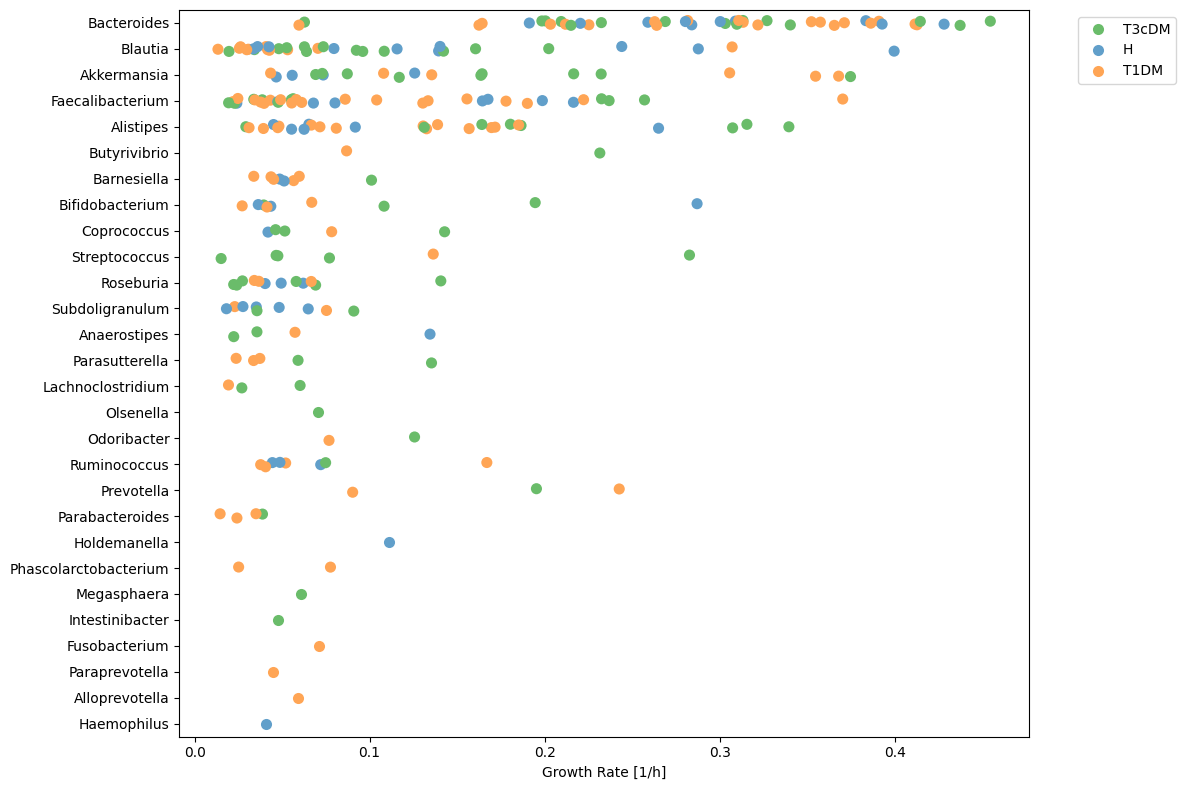

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

my_palette = {
    "T3cDM": "#6ABC6A",  
    "T1DM": "#FFA555",  
    "H": "#619FCA"      
}

plt.figure(figsize=(12, 8))
sns.stripplot(
    data=growth_rates,
    x="growth_rate",
    y="taxon",
    hue="condition",
    jitter=True,
    dodge=False,
    size=8,
    alpha=1 ,   palette=my_palette 
)

plt.title("")
plt.xlabel("Growth Rate [1/h]")
plt.ylabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="")
plt.tight_layout()
output_dir = "/data/scratch/kvalem/projects/2024/diabetes_microbe/05-results/figures"
plt.savefig(f"{output_dir}/growth_rate_by_taxon.png", format="png", dpi=300, bbox_inches="tight")
plt.savefig(f"{output_dir}/growth_rate_by_taxon.svg", format="svg", bbox_inches="tight")

plt.show()

### Plotting growth rate

In [62]:
# Loading csv from "/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/taxon_exchanges_20250624.html"
reduced = pd.read_csv("/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/materials/reduced.csv")

In [63]:
reduced

sample_id             taxon     TSNE 1     TSNE 2
0    s20011_0001       Akkermansia -41.626290 -21.268959
1    s20011_0001       Bacteroides   7.162922  19.423496
2    s20011_0001           Blautia   4.558453 -67.140450
3    s20011_0001  Faecalibacterium -13.098630 -15.627763
4    s20011_0002       Bacteroides   7.093894  21.891940
..           ...               ...        ...        ...
249  s20011_0049         Alistipes  33.732330  22.897322
250  s20011_0049       Bacteroides  28.193733  40.809850
251  s20011_0049       Barnesiella  62.278200 -21.823647
252  s20011_0049   Bifidobacterium -41.554283  35.875870
253  s20011_0049  Faecalibacterium  -5.540465 -15.249521

[254 rows x 4 columns]

In [64]:
reduced = pd.merge(reduced, metadata, on="sample_id")
reduced

sample_id             taxon     TSNE 1     TSNE 2 sample_information  \
0    s20011_0001       Akkermansia -41.626290 -21.268959                 K1   
1    s20011_0001       Bacteroides   7.162922  19.423496                 K1   
2    s20011_0001           Blautia   4.558453 -67.140450                 K1   
3    s20011_0001  Faecalibacterium -13.098630 -15.627763                 K1   
4    s20011_0002       Bacteroides   7.093894  21.891940               PDM1   
..           ...               ...        ...        ...                ...   
249  s20011_0049         Alistipes  33.732330  22.897322               DM12   
250  s20011_0049       Bacteroides  28.193733  40.809850               DM12   
251  s20011_0049       Barnesiella  62.278200 -21.823647               DM12   
252  s20011_0049   Bifidobacterium -41.554283  35.875870               DM12   
253  s20011_0049  Faecalibacterium  -5.540465 -15.249521               DM12   

     age  KHK1  KHK2   CA1   CA2  ...  Glukose1  Glukose2  BMI1  BMI2  \
0     56  nein  nein  nein  nein  ...        99      89.0  23.9  24.1   
1     56  nein  nein  nein  nein  ...        99      89.0  23.9  24.1   
2     56  nein  nein  nein  nein  ...        99      89.0  23.9  24.1   
3     56  nein  nein  nein  nein  ...        99      89.0  23.9  24.1   
4     71    ja    ja  nein  nein  ...       128       5.3  18.5  18.8   
..   ...   ...   ...   ...   ...  ...       ...       ...   ...   ...   
249   40  nein  nein  nein  nein  ...       102     101.0  24.8  25.2   
250   40  nein  nein  nein  nein  ...       102     101.0  24.8  25.2   
251   40  nein  nein  nein  nein  ...       102     101.0  24.8  25.2   
252   40  nein  nein  nein  nein  ...       102     101.0  24.8  25.2   
253   40  nein  nein  nein  nein  ...       102     101.0  24.8  25.2   

     Pankreatektomie  HbA1C_diff Glukose_diff  BMI_diff    KHK_diff CA_diff  
0               nein    increase     decrease  increase      absent  absent  
1               nein    increase     decrease  increase      absent  absent  
2               nein    increase     decrease  increase      absent  absent  
3               nein    increase     decrease  increase      absent  absent  
4               nein    increase     decrease  increase  persistent  absent  
..               ...         ...          ...       ...         ...     ...  
249             nein    increase     decrease  increase      absent  absent  
250             nein    increase     decrease  increase      absent  absent  
251             nein    increase     decrease  increase      absent  absent  
252             nein    increase     decrease  increase      absent  absent  
253             nein    increase     decrease  increase      absent  absent  

[254 rows x 22 columns]

In [84]:
# List of target taxa
target_taxa = [
    'Akkermansia', 'Blautia', 'Alistipes', 'Barnesiella',
    'Bifidobacterium', 'Subdoligranulum', 'Ruminococcus'
]

# Filter the DataFrame
reduced = reduced[reduced['taxon'].isin(target_taxa)]


In [ ]:
'Akkermansia''Blautia', 'Alistipes', 'Barnesiella', 'Bifidobacterium', 'Subdoligranulum',
'Ruminococcus'

In [66]:
def assign_condition(info):
    if "PDM" in info:
        return "T3cDM"
    elif "K" in info:
        return "H"
    else:
        return "T1DM"

reduced['condition'] = reduced['sample_information'].apply(assign_condition)

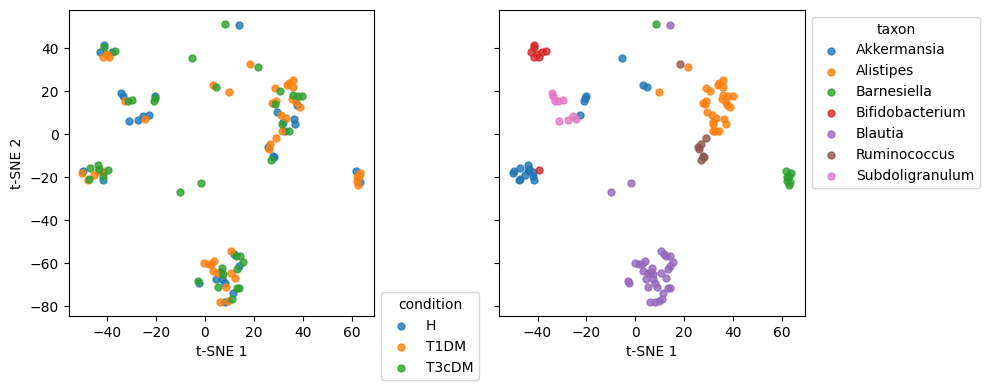

In [104]:
import matplotlib.pyplot as plt

# Step 1: Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

for cond, group in reduced.groupby("taxon"):
    axes[1].scatter(group["TSNE 1"], group["TSNE 2"], label=cond, alpha=0.8, s=25)
axes[1].set_title("")
axes[1].set_xlabel("t-SNE 1")
axes[1].legend(title="taxon", bbox_to_anchor=(1, 1), loc="upper left")

# Step 2: Plot colored by taxon
for taxon, group in reduced.groupby("condition"):
    axes[0].scatter(group["TSNE 1"], group["TSNE 2"], label=taxon, alpha=0.8, s=25)
axes[0].set_title("")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")
axes[0].legend(title="condition", bbox_to_anchor=(1, 0.1), loc="upper left")

# Step 3: Plot colored by condition


plt.tight_layout()

plt.savefig(f"{output_dir}/tsne_metabolism_flux.png", format="png", dpi=300, bbox_inches="tight")
plt.savefig(f"{output_dir}/tsne_metabolism_flux.svg", format="svg", dpi=300, bbox_inches="tight")
plt.show()